##### Sami Ramzi Chibane © 

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point
import osmnx  as ox
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# creating the origin from Kissing Students
origin = gpd.GeoDataFrame(columns = ['name', 'geometry'], crs = 4326, geometry = 'geometry')
origin.at[0, 'geometry'] = Point(43.304315, 5.394611)
origin.at[0, 'name'] = 'Palais Longchamp'

In [4]:
origin.head()

name                  geometry
0  Palais Longchamp  POINT (43.30432 5.39461)

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


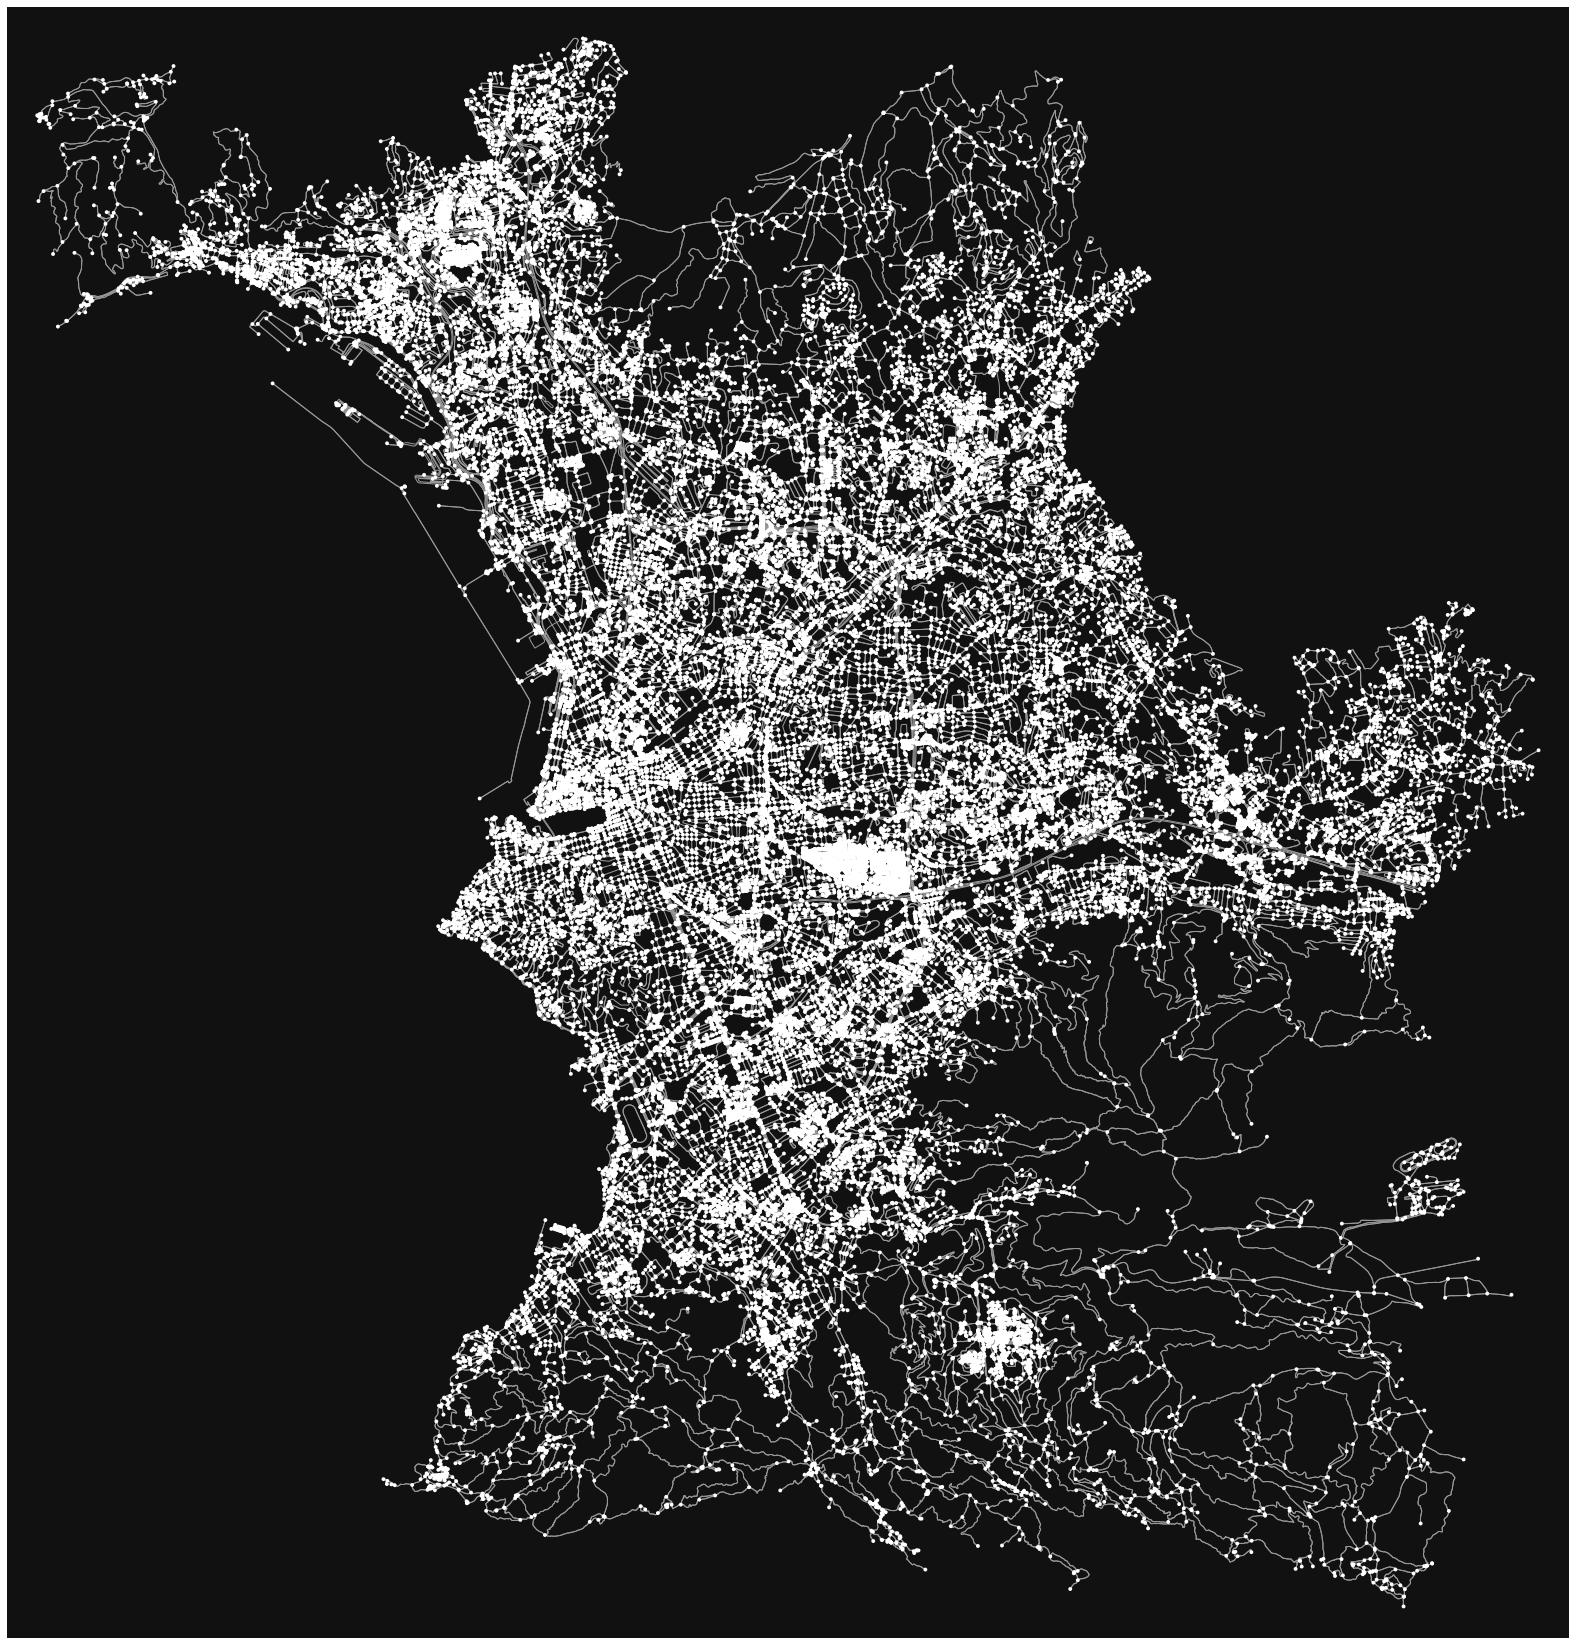

In [7]:
# fetching cafes as the destinations from OSM

# Specify the name that is used to seach for the data
place_name = 'Marseille, France'

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)

# Plot the streets
fig, ax = ox.plot_graph(graph, figsize=(30, 30))

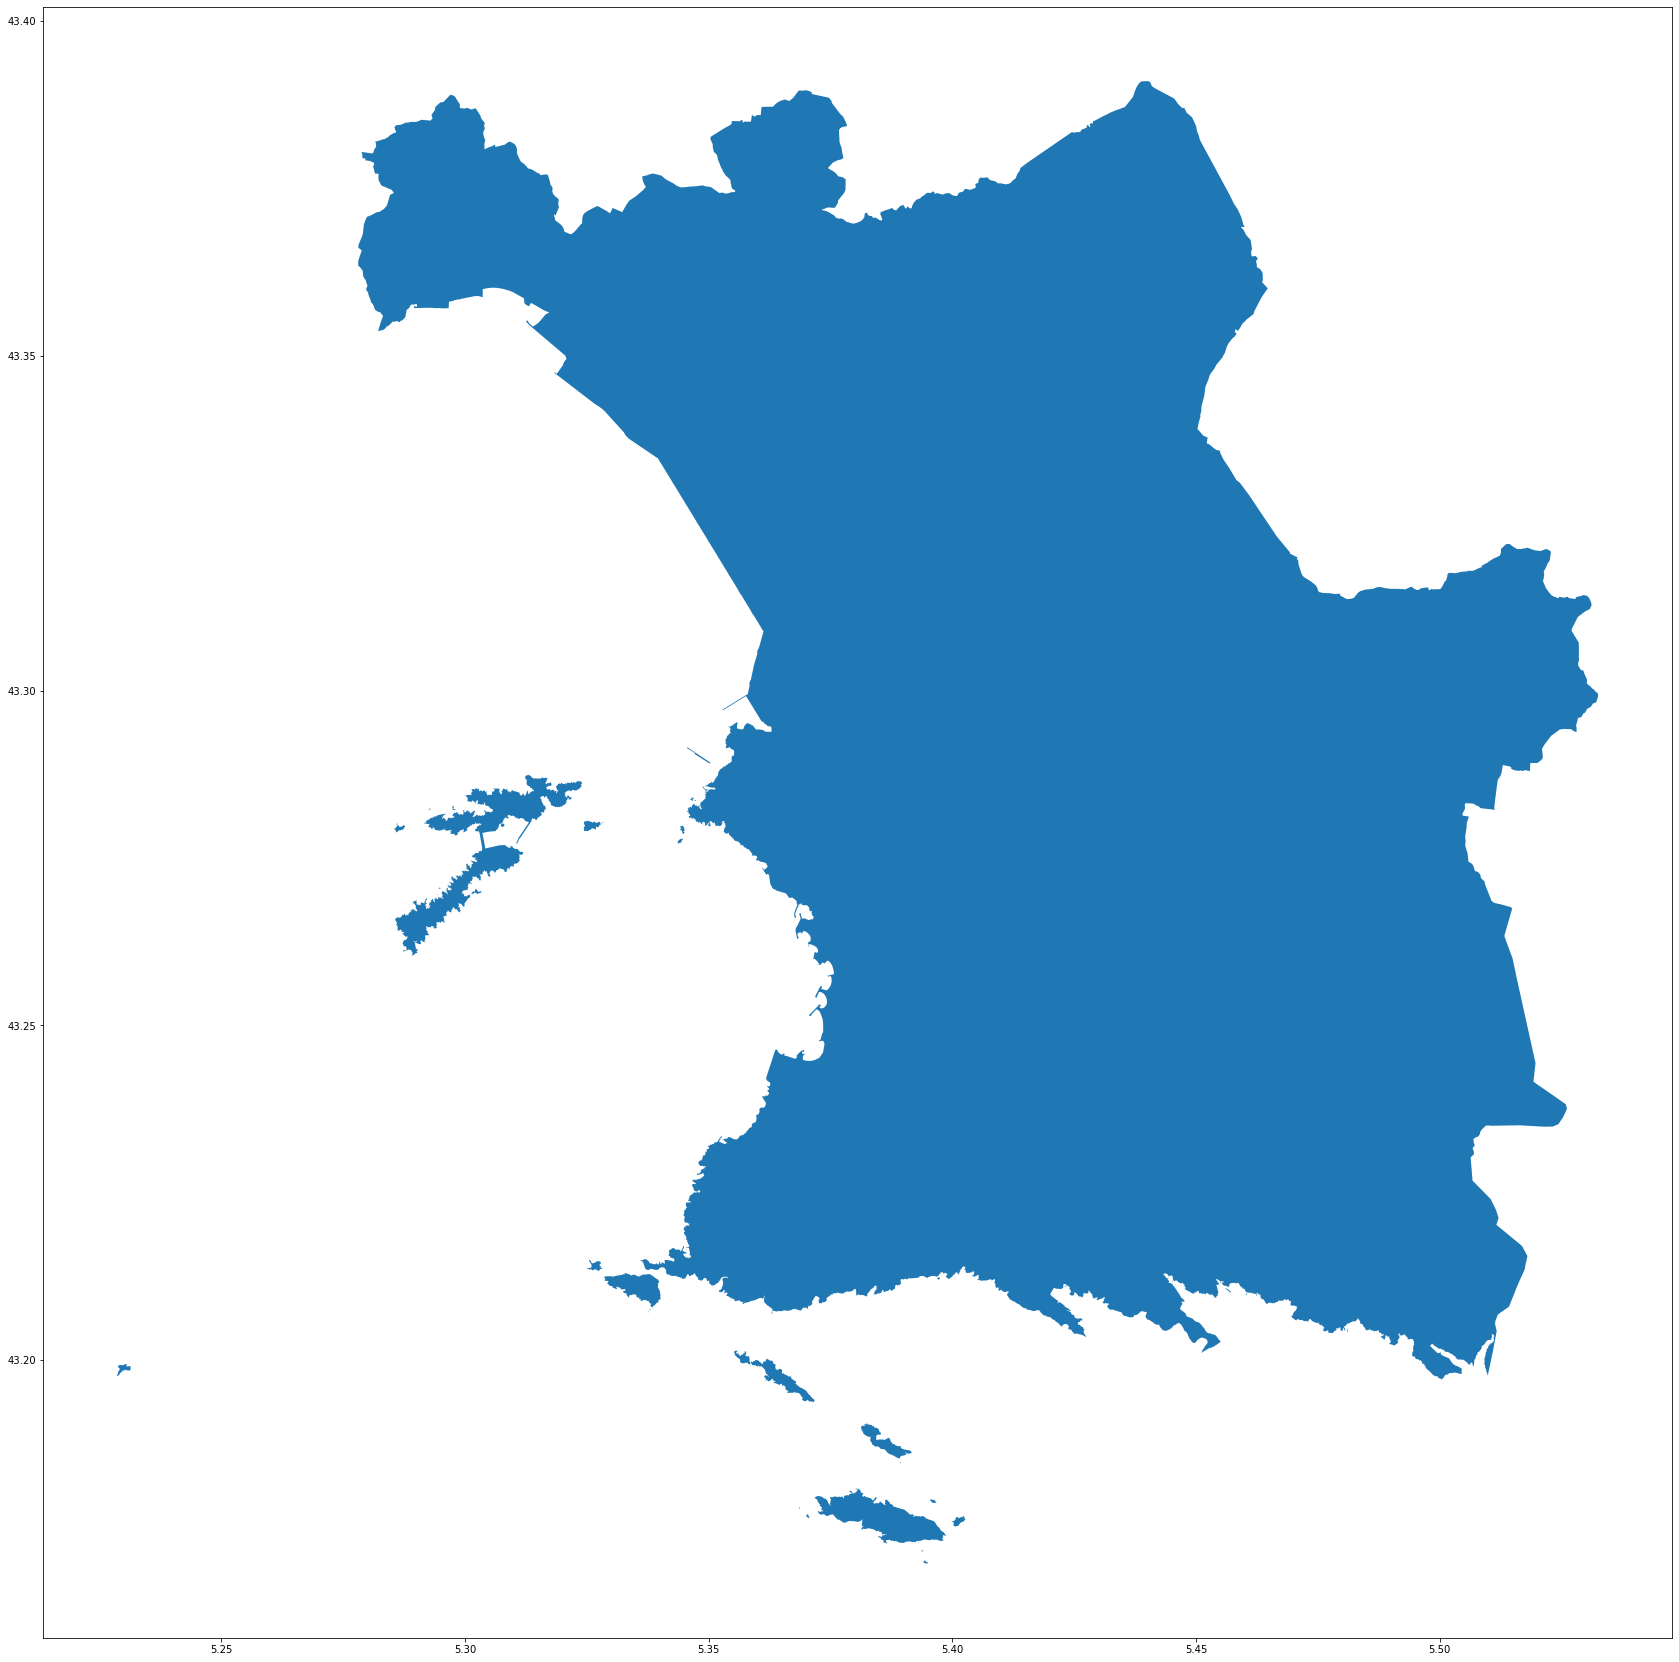

In [9]:
# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)
area.plot(figsize=(30, 30));

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


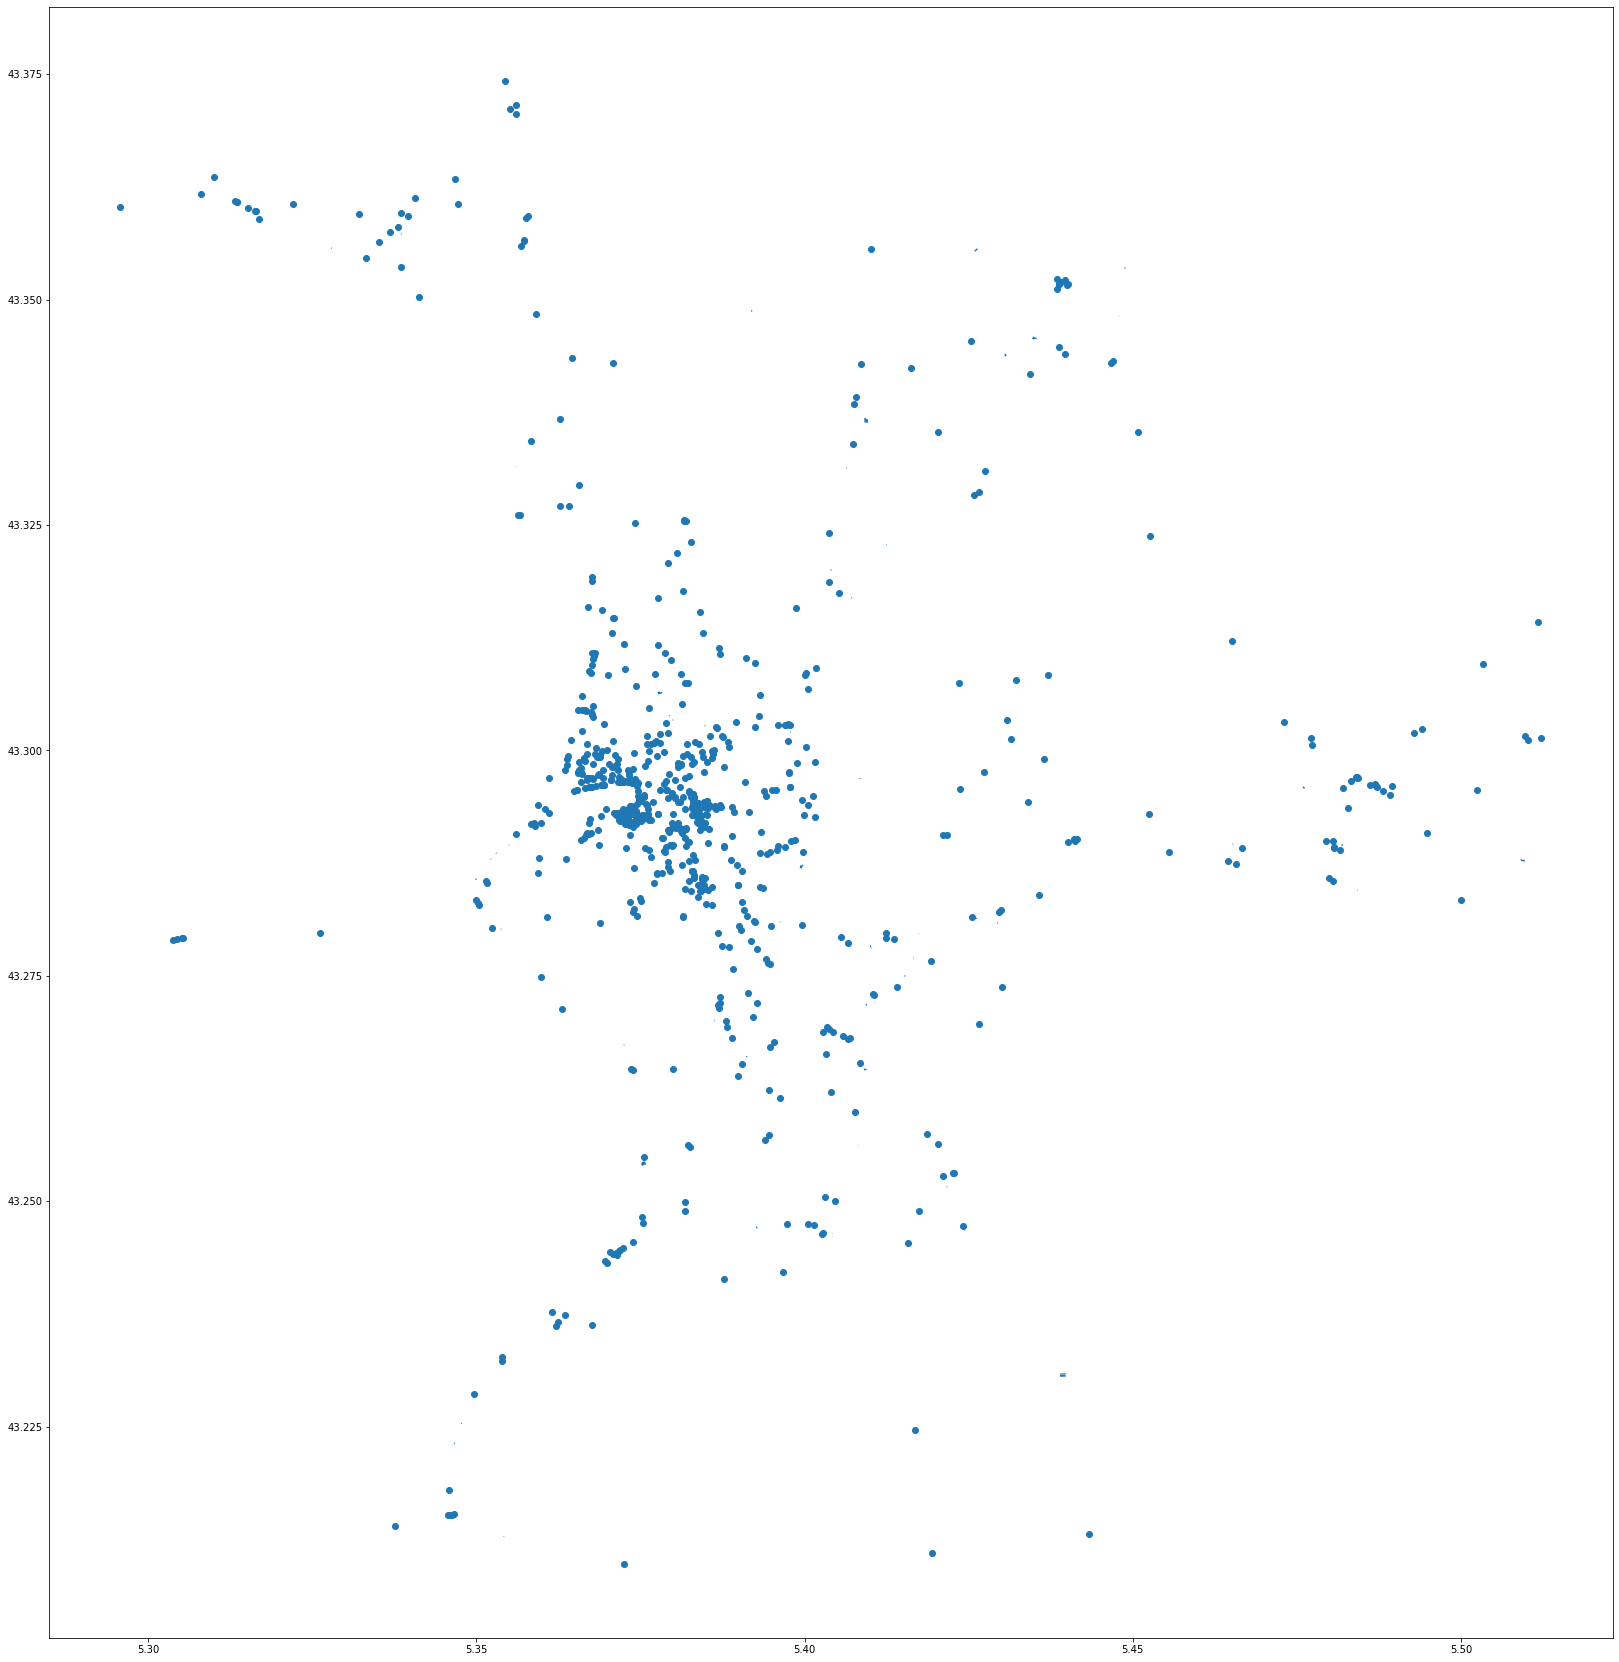

In [11]:
# List key-value pairs for tags
tags = {'amenity': 'restaurant'}

# Get the data
restaurants = ox.geometries_from_place(place_name, tags)

restaurants.plot(figsize=(30, 30));

In [14]:
restaurants = restaurants[['name', 'geometry']]
restaurants = restaurants.reset_index(drop=True)

# getting centroids from polygons to avoid polygon geometric objects
restaurants['geometry'] = [geom.centroid for geom in restaurants['geometry']]

print(len(restaurants))
restaurants.head(10)

846


name                  geometry
0       Chez Mario  POINT (5.37295 43.29305)
1        Post Café  POINT (5.37388 43.29799)
2    Soleil pressé  POINT (5.37400 43.29969)
3           Fonfon  POINT (5.35143 43.28554)
4     Chez Jeannot  POINT (5.35164 43.28528)
5       Le Planète  POINT (5.37628 43.29992)
6    La Cantinetta  POINT (5.38246 43.29533)
7       La Cantine  POINT (5.37295 43.29242)
8      Shabu Shabu  POINT (5.37277 43.29218)
9  Au Vieux Moulin  POINT (5.40781 43.33924)

In [15]:
# FUNCTION
def shortest_path(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe> crs 4326, network <str> drive, bike, walk
    return shortest path <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Reproject the graph
    graph_proj = ox.project_graph(graph)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph_proj, nodes=False)
    
    # Get CRS info UTM
    CRS = edges.crs
    
    # Reproject all data
    origin_proj = origin.to_crs(crs=CRS)
    destination_proj = destination.to_crs(crs=CRS)
    
    # routes of shortest path
    routes = gpd.GeoDataFrame()
    
    # Get nodes from the graph
    nodes = ox.graph_to_gdfs(graph_proj, edges=False)
    
    # Iterate over origins and destinations
    for oidx, orig in origin_proj.iterrows():
        
        # Find closest node from the graph --> point = (latitude, longitude)
        closest_origin_node = ox.get_nearest_node(G=graph_proj, point=(orig.geometry.y, orig.geometry.x), method='euclidean')
        
        # Iterate over targets
        for tidx, target in destination_proj.iterrows():
            
            # Find closest node from the graph --> point = (latitude, longitude)
            closest_target_node = ox.get_nearest_node(graph_proj, point=(target.geometry.y, target.geometry.x), method='euclidean')

            # Check if origin and target nodes are the same --> if they are --> skip
            if closest_origin_node == closest_target_node:
                print("Same origin and destination node. Skipping ..")
                continue
            
            # Find the shortest path between the points
            route = nx.shortest_path(graph_proj, 
                                     source=closest_origin_node, 
                                     target=closest_target_node, weight='length')
        
            # Extract the nodes of the route
            route_nodes = nodes.loc[route]
        
            # Create a LineString out of the route
            path = LineString(list(route_nodes.geometry.values))
        
            # Append the result into the GeoDataFrame
            routes = routes.append([[path]], ignore_index=True)

    # Add a column name
    routes.columns = ['geometry']        

    # Set geometry
    routes = routes.set_geometry('geometry')
    
    # Set coordinate reference system
    routes.crs = nodes.crs
    
    return routes   

In [16]:
routes = shortest_path(origin, restaurants, network = 'walk')

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [17]:
routes['distance'] = routes['geometry'].length

In [18]:
routes.crs

<Derived Projected CRS: +proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 31N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [19]:
routes.head()

geometry      distance
0  LINESTRING (717141.946 4784352.842, 716783.657...  31706.518657
1  LINESTRING (717141.946 4784352.842, 716783.657...  31829.896995
2  LINESTRING (717141.946 4784352.842, 716783.657...  31994.469389
3  LINESTRING (717141.946 4784352.842, 716783.657...  32978.782343
4  LINESTRING (717141.946 4784352.842, 716783.657...  32958.854498

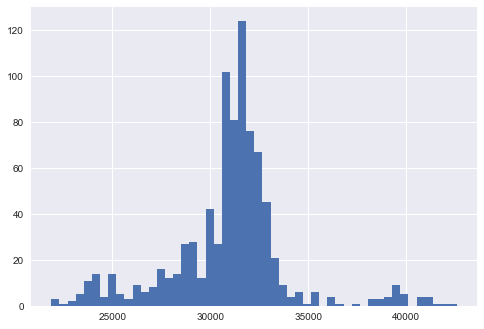

In [20]:
plt.style.use('seaborn')
routes['distance'].hist(bins=50);

In [22]:
routes_wgs = routes.to_crs(4326)

In [25]:
routes_wgs.to_file(r'walking_routes.geojson', driver='GeoJSON')
restaurants.to_file(r'restaurants_tartu.geojson', driver='GeoJSON')
origin.to_file(r'kissing_students.geojson', driver='GeoJSON')
area.to_file(r'tartu_area.geojson', driver='GeoJSON')

In [26]:
# fetching walking network
def osm_network(origin, destination, network = 'drive'):
    '''origin and destination <geodataframe>, network <str> drive, bike, or walk
    return network <GeoDataFrame>
    '''
    
    # creating a frame for fetching OSM data
    combined = origin.append(destination)
    
    convex = combined.unary_union.convex_hull
    
    graph_extent = convex.buffer(0.02)
    
    # fetching graph
    graph = ox.graph_from_polygon(graph_extent, network_type= network)
    
    # Get the GeoDataFrame
    edges = ox.graph_to_gdfs(graph, nodes=False)
    
    return edges

In [27]:
walking_network = osm_network(origin, restaurants, network = 'walk')

C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
C:\Users\Chibane\anaconda3\envs\ox\lib\site-packages\osmnx\utils_geo.py:374: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


In [28]:
walking_network = walking_network[['geometry']]
walking_network = walking_network.reset_index(drop=True)

walking_network.head()

geometry
0  LINESTRING (5.48633 43.33165, 5.48638 43.33161...
1  LINESTRING (5.48633 43.33165, 5.48632 43.33168...
2  LINESTRING (5.48633 43.33165, 5.48632 43.33157...
3  LINESTRING (5.47721 43.33551, 5.47729 43.33542...
4  LINESTRING (5.47721 43.33551, 5.47728 43.33552...

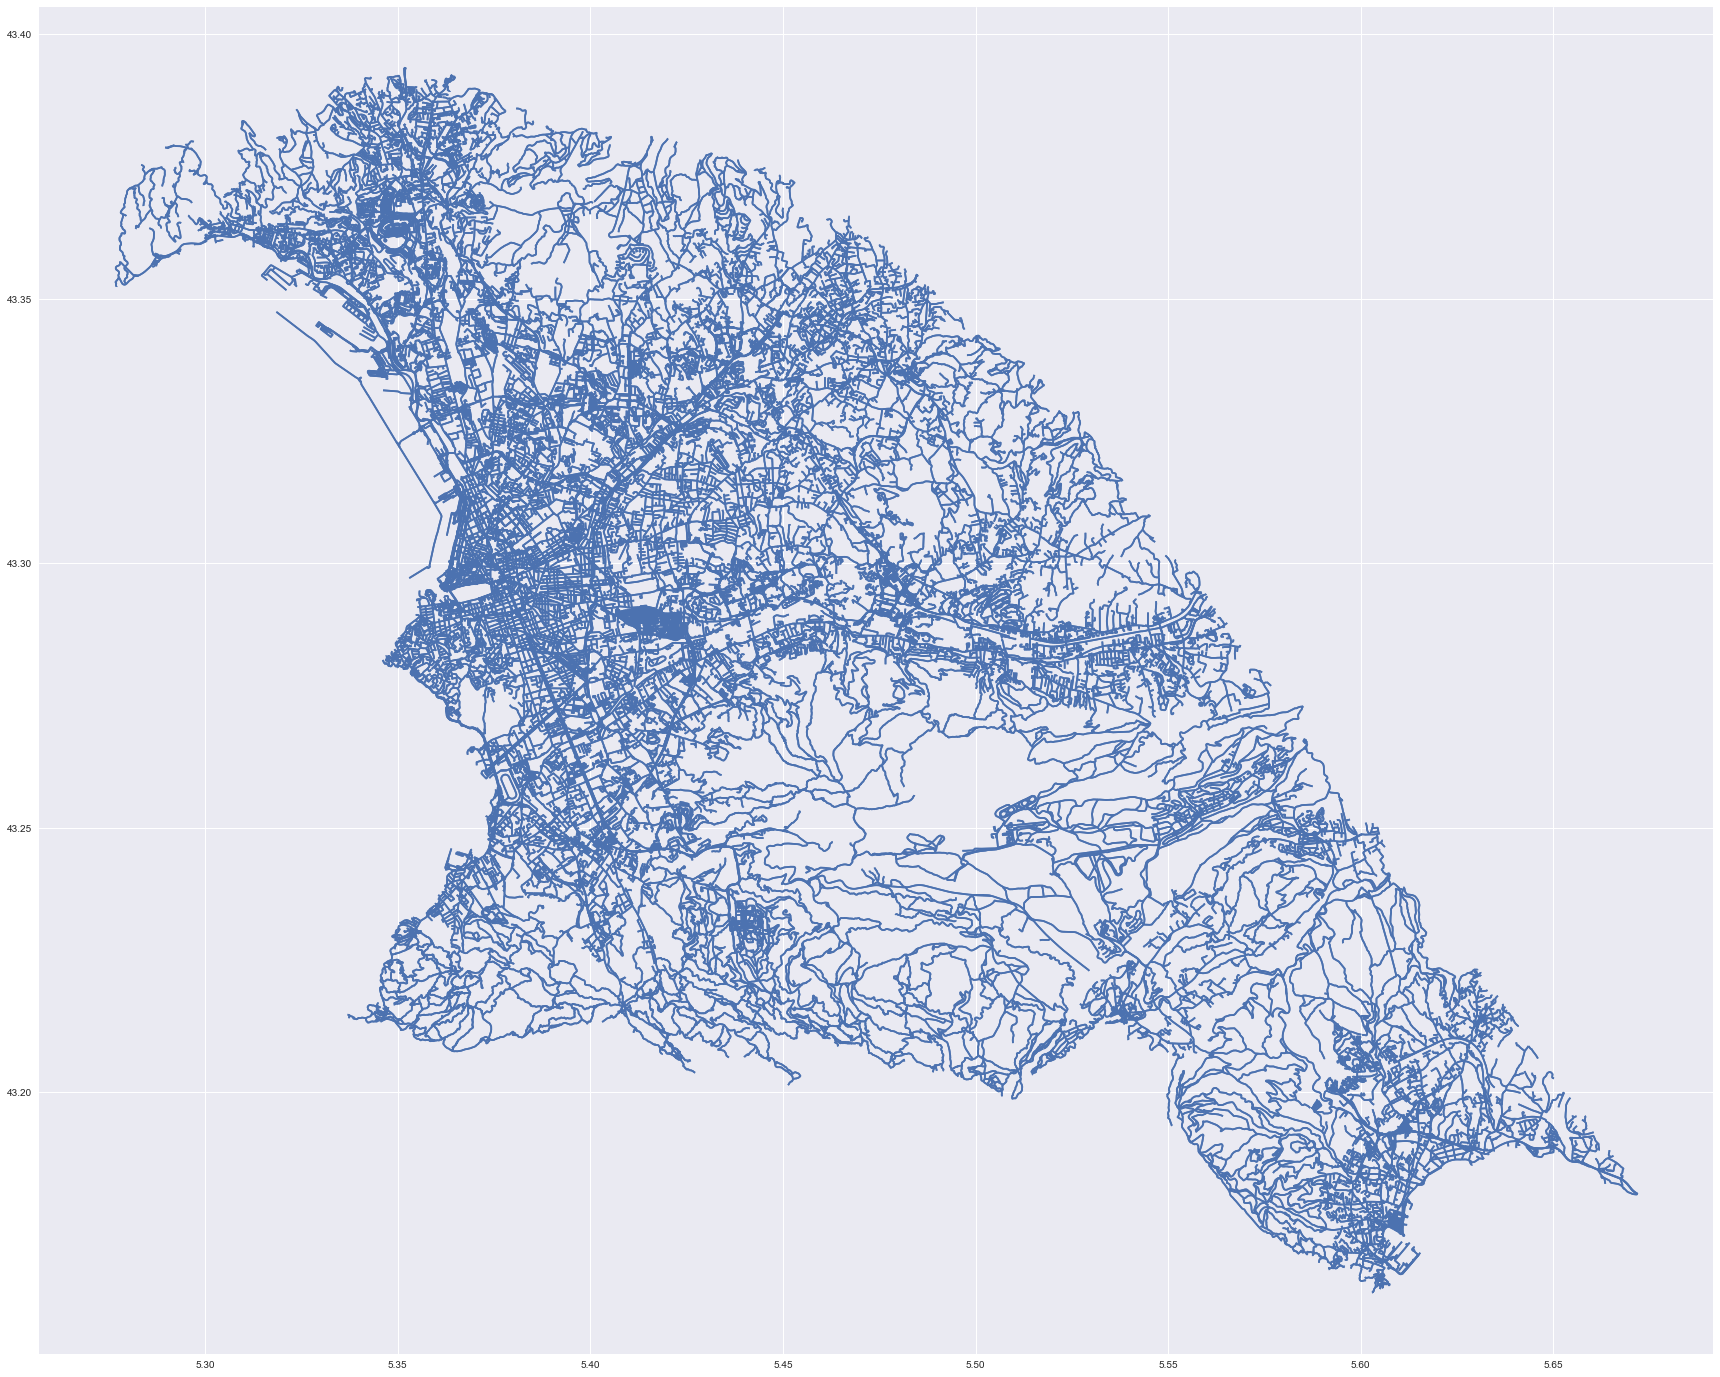

In [29]:
walking_network.plot(figsize=(30, 30));

In [30]:
walking_network.to_file(r'walk_network.geojson', driver='GeoJSON')

In [31]:
import geojsonio